# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [3]:
import sklearn

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [4]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [5]:
# Student Note: I reduced the sample size due to the kernel crashing.
N_Train=100000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]

We can train the classifier as follow:

In [6]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

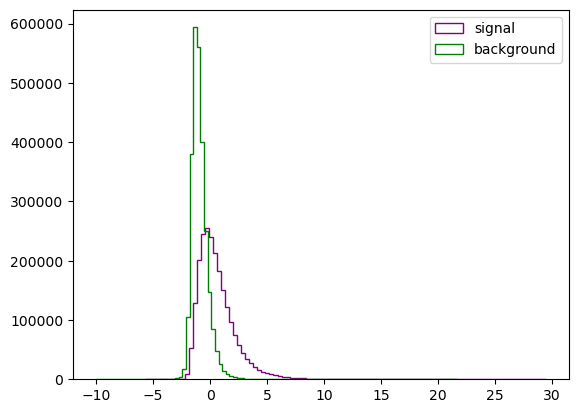

In [7]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="purple", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="green", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

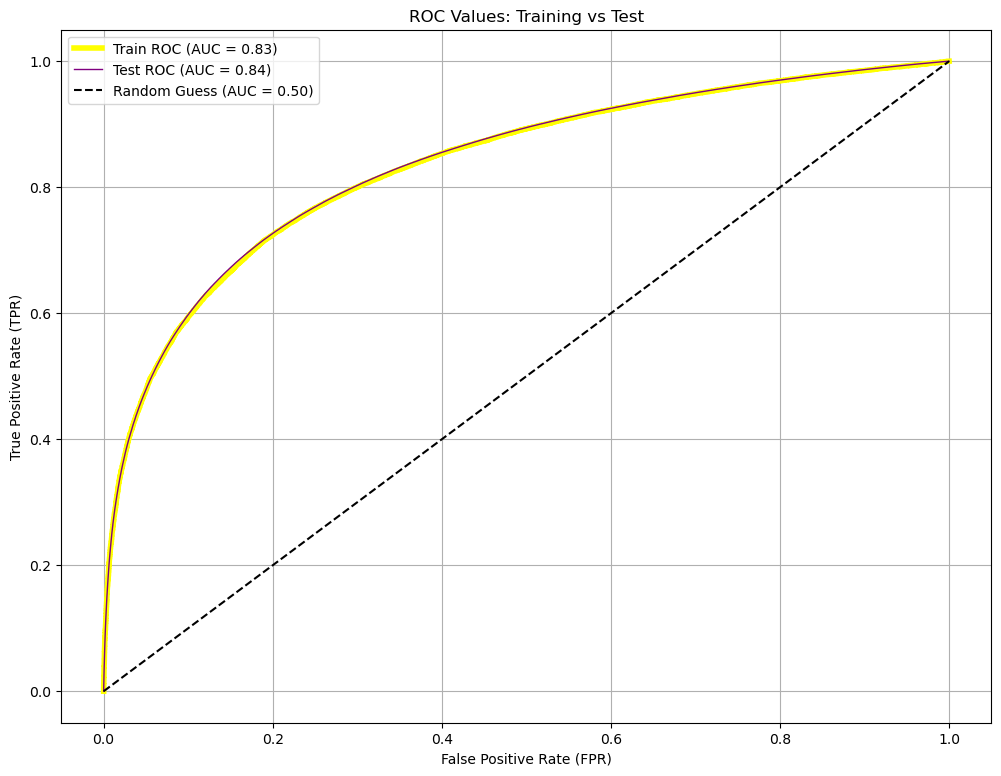

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute probability scores for positive class X_train and the training/test sets
y_Train_prob = Fisher.predict_proba(X_Train)[:, 1]
y_Test_prob = Fisher.predict_proba(X_Test)[:, 1]

# Calculate ROC Values
fpr_train, tpr_train, _ = roc_curve(y_Train, y_Train_prob)
fpr_test, tpr_test, _ = roc_curve(y_Test, y_Test_prob)

# Calculate AUC Values
auc_test = roc_auc_score(y_Test, y_Test_prob)
auc_train = roc_auc_score(y_Train, y_Train_prob)

# Plot ROC Curves
plt.figure(figsize=(12, 9))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})', color='yellow', linewidth=4)
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})', color='purple', linewidth=1)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

plt.title('ROC Values: Training vs Test')
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [23]:
# There is little to no bias because the lines almost fully cover each other.
# I used a smaller sample size due to the kernel crashing constantly, so that may be why they don't fully overlap.

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

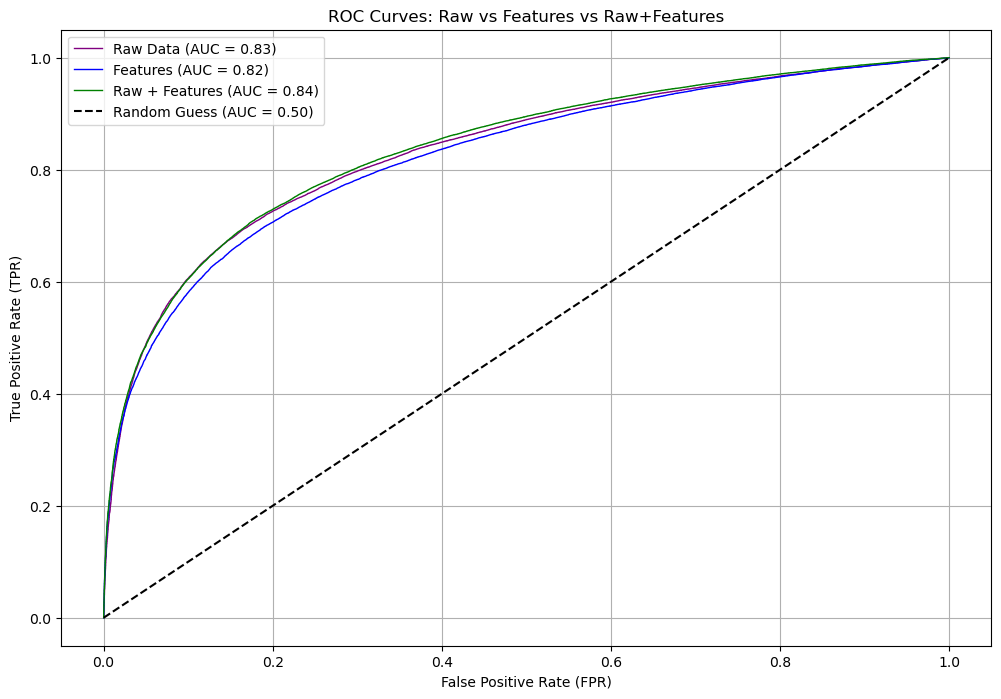

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import gc

# Define feature groups.
low_level_features = ['l_1_pT', 'l_1_eta', 'l_1_phi', 'l_2_pT', 'l_2_eta', 'l_2_phi', 'MET', 'MET_phi']
high_level_features = ['MET_rel', 'dPhi_r_b', 'cos_theta_r1', 'R', 'M_TR_2', 'MT2', 'M_R', 'M_Delta_R', 'S_R', 'axial_MET']

# Reduce sample size to prevent crashing.
df = df.sample(n=100000, random_state=42).reset_index(drop=True)

# Create input DataFrames.
X_raw = df[low_level_features]
X_features = df[high_level_features]

# Standardize features.
scaler = StandardScaler()
X_raw = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
X_features = pd.DataFrame(scaler.fit_transform(X_features), columns=X_features.columns)
X_combined = pd.concat([X_raw, X_features], axis=1)

# Split datasets.
N_Train = 10000
X_raw_train, X_raw_test = X_raw[:N_Train], X_raw[N_Train:]
X_features_train, X_features_test = X_features[:N_Train], X_features[N_Train:]
X_combined_train, X_combined_test = X_combined[:N_Train], X_combined[N_Train:]
y_train, y_test = df['signal'][:N_Train], df['signal'][N_Train:]

# Run garbage collection to prevent crashing.
gc.collect()

# Initialize LDA models with stable solver.
Fisher_raw = LinearDiscriminantAnalysis(solver='lsqr')
Fisher_features = LinearDiscriminantAnalysis(solver='lsqr')
Fisher_combined = LinearDiscriminantAnalysis(solver='lsqr')

# Train the models.
Fisher_raw.fit(X_raw_train, y_train)
Fisher_features.fit(X_features_train, y_train)
Fisher_combined.fit(X_combined_train, y_train)

# Skip predictions if no test data exists.
y_raw_prob = y_features_prob = y_combined_prob = np.array([])
if len(X_raw_test) > 0 and len(X_features_test) > 0 and len(X_combined_test) > 0:
    y_raw_prob = Fisher_raw.predict_proba(X_raw_test)[:, 1]
    y_features_prob = Fisher_features.predict_proba(X_features_test)[:, 1]
    y_combined_prob = Fisher_combined.predict_proba(X_combined_test)[:, 1]

    # Calculate ROC curves and AUCs.
    fpr_raw, tpr_raw, _ = roc_curve(y_test, y_raw_prob)
    fpr_features, tpr_features, _ = roc_curve(y_test, y_features_prob)
    fpr_combined, tpr_combined, _ = roc_curve(y_test, y_combined_prob)

    auc_raw = roc_auc_score(y_test, y_raw_prob)
    auc_features = roc_auc_score(y_test, y_features_prob)
    auc_combined = roc_auc_score(y_test, y_combined_prob)

    # Plot ROC curves.
    plt.figure(figsize=(12, 8))
    plt.plot(fpr_raw, tpr_raw, label=f'Raw Data (AUC = {auc_raw:.2f})', color='purple', linewidth=1)
    plt.plot(fpr_features, tpr_features, label=f'Features (AUC = {auc_features:.2f})', color='blue', linewidth=1)
    plt.plot(fpr_combined, tpr_combined, label=f'Raw + Features (AUC = {auc_combined:.2f})', color='green', linewidth=1)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

    plt.title('ROC Curves: Raw vs Features vs Raw+Features')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
else:
    print("Test data is empty. Skipping prediction and ROC plotting.")

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

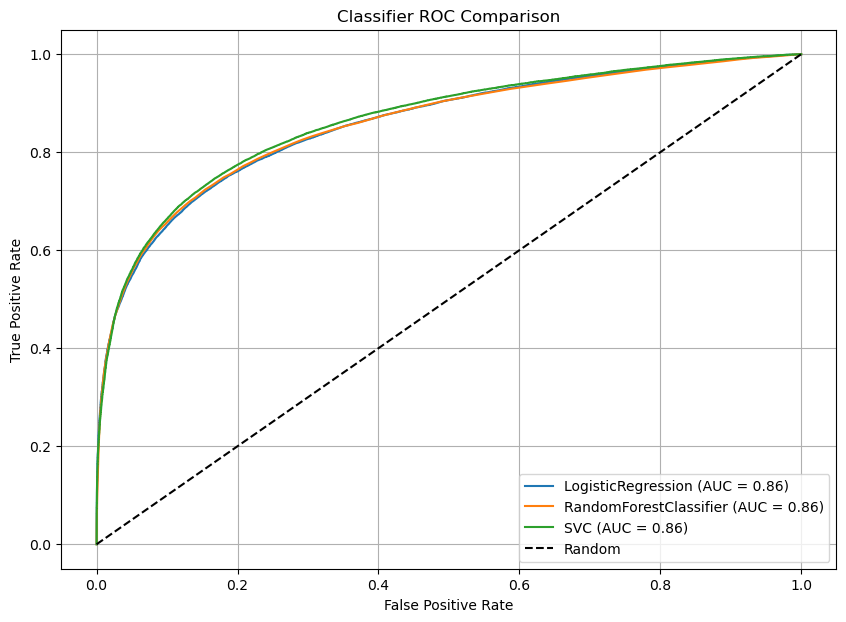

Maximal Significance for best model (Support Vector Machine): 154.1726


In [22]:
### Part 4a ###
# 1) Logistic Regression (1.1.11)
# 2) Support Vectors (1.4.1 to 1.4.8)
# 3) Random Forests (1.11.2)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(probability=True)
}

### Part 4b ###
def evaluate_classifier(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{clf.__class__.__name__} (AUC = {auc:.2f})")
    return y_proba, auc

plt.figure(figsize=(10, 7))
results = {}
for name, clf in classifiers.items():
    proba, auc = evaluate_classifier(clf, X_combined_train, X_combined_test, y_train, y_test)
    results[name] = {"proba": proba, "auc": auc}

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier ROC Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Part 4c ###
def compute_significance(y_true, y_scores, threshold=0.5):
    y_pred = (y_scores > threshold).astype(int)
    N_S = np.sum((y_true == 1) & (y_pred == 1))
    N_B = np.sum((y_true == 0) & (y_pred == 1))
    if N_S + N_B == 0:
        return 0
    return N_S / np.sqrt(N_S + N_B)

best_model = max(results.items(), key=lambda x: x[1]['auc'])
best_proba = best_model[1]['proba']
significance = compute_significance(y_test.values, best_proba)
print(f"Maximal Significance for best model ({best_model[0]}): {significance:.4f}")

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 



Model Evaluation Metrics:
 TPR (Recall)      FPR     AUC  Precision  F1 Score  Accuracy  Max Significance
     0.704992 0.999816 0.86408    0.82059  0.758411  0.794956        154.172646


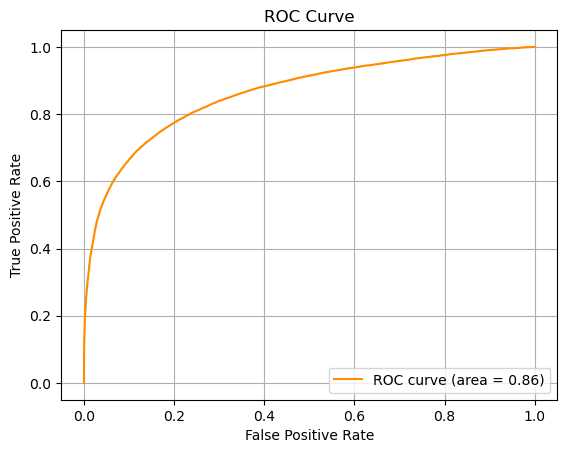

In [24]:
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score,
    f1_score, accuracy_score
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_significance(y_true, y_scores, threshold=0.5):
    y_pred = (y_scores > threshold).astype(int)
    N_S = np.sum((y_true == 1) & (y_pred == 1))
    N_B = np.sum((y_true == 0) & (y_pred == 1))
    if N_S + N_B == 0:
        return 0
    return N_S / np.sqrt(N_S + N_B)

# Define an evaluation of matrics function.
def evaluate_metrics(y_true, y_scores, threshold=0.5):
    y_pred = (y_scores > threshold).astype(int)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    significance = compute_significance(y_true, y_scores, threshold)

    # Return the results of the evaluation as dictionary
    return {
        "TPR (Recall)": recall,
        "FPR": fpr[np.argmax(tpr)],  # rough estimate
        "AUC": roc_auc,
        "Precision": precision,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "Max Significance": significance
    }

# Example use with best classifier from Part 4c:
results = evaluate_metrics(y_test, best_proba)

# Create a table with our data.
results_df = pd.DataFrame([results])
print("\nModel Evaluation Metrics:")
print(results_df.to_string(index=False))

# Create a plot of the ROC curve.
fpr, tpr, _ = roc_curve(y_test, best_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()